# Neural Network implementation for Racetime prediction

### Imports

In [129]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl
import pandas as pd
import os
import numpy as np

### Constants

In [130]:
DATA_DIR = "../data"
USED_FEATURES = [
    "raceId", 
    "driverId", 
    "constructorId",
    "grid",
    "round",
    "circuitId",
    "race_lat",
    "race_lng",
    "race_alt",
    "avg_pit_stop_duration",
    "max_pit_stop_duration",
    "avg_pit_stop_duration",
    "std_pit_stop_duration",
    "milliseconds_count",
    "pit_stop_count",
    "min_pit_stop_lap",
    "max_pit_stop_lap",
    "avg_pit_stop_lap",
    "std_pit_stop_lap",
    "avg_pit_stop_driver",
    "avg_pit_stop_team",
    "avg_pit_stop_track",
    "avg_pit_stop_season",
    "rolling_avg_pit_stop_driver",
    "rolling_avg_pit_stop_team",
    "rolling_avg_pit_stop_track",
    "rolling_avg_pit_stop_season",
    "milliseconds_count",
]

### Dataset

In [131]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

class F1Dataset(Dataset):
    def __init__(self, filepath, year_from, year_to):
        # year_from inclusive, year_to exclusive
        super().__init__()
        self.year_from = year_from
        self.year_to = year_to

        data = pd.read_csv(filepath)
        data = data[data["year"] >= self.year_from]
        data = data[data["year"] < self.year_to]

        # Ensure all data is numeric and handle missing values
        x = data[USED_FEATURES].apply(pd.to_numeric, errors='coerce').fillna(0)

        # Normalize the data
        scaler = StandardScaler()
        self.x = scaler.fit_transform(x)
        self.y = data["position"].apply(pd.to_numeric, errors='coerce').fillna(0).to_numpy()

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = torch.tensor(self.x[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.float32)

        return x, y


# Load the dataset
dataset = F1Dataset(os.path.join(DATA_DIR, "processed/export_v1.csv"), year_from=2018, year_to=2025)

# Split the dataset into train and test sets (70:30 split)
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=test_size, random_state=42)

train_subset = Subset(dataset, train_indices)
test_subset = Subset(dataset, test_indices)

# Create DataLoaders
train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=16)
    
data_2018_2025 = F1Dataset(os.path.join(DATA_DIR, "processed/export_v1.csv"), 2018, 2025)
print(f"Amount of features used: {data_2018_2025.__getitem__(0)[0].shape[0]}")
data_2018_2025.__getitem__(0)

Amount of features used: 28


/var/folders/mz/1fcctw7n0d1b3ql1xgckmytc0000gn/T/ipykernel_70692/3136305662.py:15: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filepath)
/var/folders/mz/1fcctw7n0d1b3ql1xgckmytc0000gn/T/ipykernel_70692/3136305662.py:15: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filepath)


(tensor([-1.6841, -2.1720, -0.8525, -1.2133, -1.6349, -1.0612, -3.2844,  2.1573,
         -0.5303, -0.2898, -0.3240, -0.2898, -0.3048, -0.6939, -0.6939,  0.7778,
         -0.2874,  0.1963, -0.9152,  1.9467, -0.8545,  0.6133, -1.1890,  0.7071,
          0.6790,  0.7081, -0.5031, -0.6939]),
 tensor(3.))

### Model

In [132]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import matplotlib.pyplot as plt

class PositionPredictionModel(pl.LightningModule):
    def __init__(self, input_dim=len(USED_FEATURES), hidden_dim=64, output_dim=1, lr=1e-3, loss_fn=nn.L1Loss):
        super().__init__()
        self.save_hyperparameters()
        self.predictions = []
        self.actuals = []
        
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),  # Regularization
            
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(hidden_dim * 2, hidden_dim * 4),
            nn.BatchNorm1d(hidden_dim * 4),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            
            nn.Linear(hidden_dim, output_dim),
        )
        
        self.loss_fn = loss_fn()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss_fn(y_hat, y)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss_fn(y_hat, y)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss_fn(y_hat, y)
        self.predictions.extend(y_hat.cpu().numpy())
        self.actuals.extend(y.cpu().numpy())
        return loss
    
    def on_test_epoch_end(self):
        plt.figure(figsize=(8, 6))
        plt.scatter(self.actuals, self.predictions, alpha=0.6, edgecolor='k')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title('Correlation between Actual and Predicted Values')
        plt.grid(True)
        plt.show()

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=self.hparams.lr,
            steps_per_epoch=100,
            epochs=10,
            anneal_strategy='cos',
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': scheduler,
            'monitor': 'val_loss'
        }

model = PositionPredictionModel()
model

PositionPredictionModel(
  (model): Sequential(
    (0): Linear(in_features=28, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=128, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=256, out_features=128, bias=True)
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.2, inplace=False)
    (16): Linear(in_features=128, out_features=64, bias=True)
    (17): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=Tr

### Training

In [133]:
trainer = pl.Trainer(max_epochs=25, log_every_n_steps=10)
trainer.fit(model, train_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | Sequential | 85.7 K | train
1 | loss_fn | L1Loss     | 0      | train
-----------------------------------------------
85.7 K    Trainable params
0         Non-trainable params
85.7 K    Total params
0.343     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode
/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be 

Training: |          | 0/? [00:00<?, ?it/s]

/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
`Trainer.fit` stopped: `max_epochs=25` reached.


### Evaluation

/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


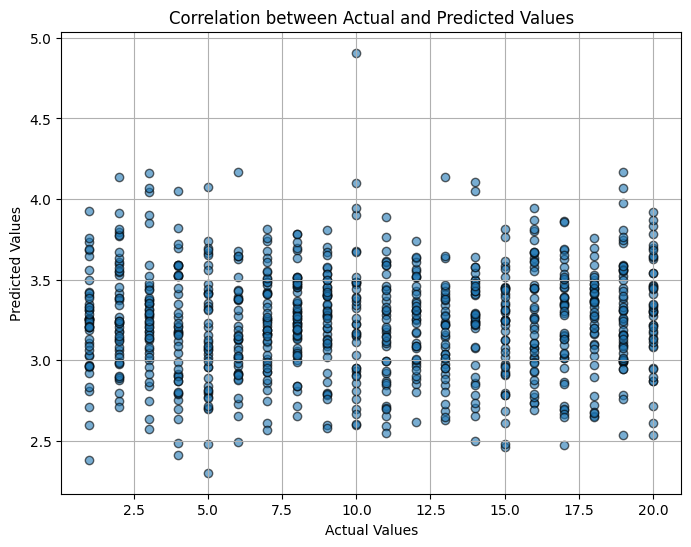

[{}]

In [134]:
trainer.test(model, test_loader)

In [135]:
%reload_ext tensorboard
%tensorboard --logdir=neural_net/lightning_logs

Launching TensorBoard...